In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy.io
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import sklearn.datasets
import re
import seaborn as sns
import datetime as dt
import time
from tensorflow.python.framework import ops
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#from DNN_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# read the preprocessed data
rawdata = pd.read_csv('raw_data.csv')

In [31]:
# split the data
y = list(rawdata['target'])
X = rawdata[numCols+catCols]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.2,random_state=1)


In [ ]:
catCols = ['BorrName', 'BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc','NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols = ['BorrZip','CDC_Zip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borr=third','borr=pro','borr=CDC','total','termint']


In [169]:
# try to drop some features
catCols1 = ['BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols1 = ['BorrZip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borr=CDC','total','termint']

y1 = list(rawdata['target'])
X1 = rawdata[numCols1+catCols1]
train_X1, test_X1, train_y1, test_y1 = train_test_split(X1,y1,test_size=0.2,random_state=1)
train_X1, val_X1, train_y1, val_y1 = train_test_split(train_X1,train_y1,test_size=0.2,random_state=1)

## Baseline: Logistic Regression

In [29]:
# standardization and one-hot encoding
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.42      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8471537070370873

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8471537070370873


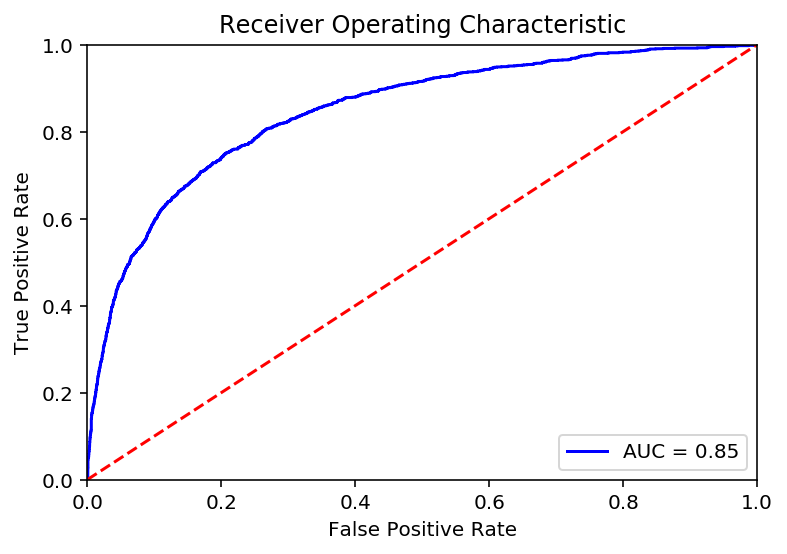

In [30]:
# ROC_AUC curve for logistic regression
probs = clf.predict_proba(val_X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(val_y, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression with Regularization

#### L1

In [150]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l1'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.41      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8463871324301293


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### L2

In [151]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l2'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.42      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8475466910992825


## Tree Models

### Gradient Boosting

In [73]:
def run_lgbc(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "binary",
        "metric" : "binary_logloss", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)

    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


In [77]:
modelC, pred_val_y = run_lgbc(train_X, train_y, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.322689
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.311513
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.69      0.42      0.52      1408

   micro avg       0.88      0.88      0.88      8769
   macro avg       0.79      0.69      0.72      8769
weighted avg       0.86      0.88      0.86      8769

0.8544310038470564


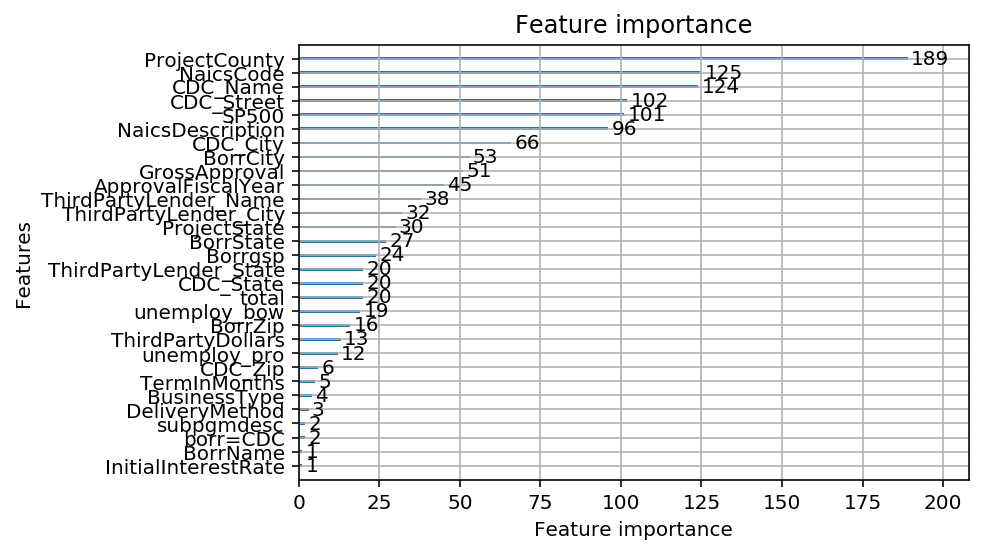

In [33]:
lgb.plot_importance(modelC)

In [37]:
fn = modelC.feature_name()
fi = list(modelC.feature_importance())
for i in range(len(fn)):
    print(fn[i],fi[i])

BorrZip 16
CDC_Zip 6
ThirdPartyDollars 13
GrossApproval 51
InitialInterestRate 1
TermInMonths 5
Borrgsp 24
unemploy_bow 19
unemploy_pro 12
SP500 101
borr=third 0
borr=pro 0
borr=CDC 2
total 20
termint 0
BorrName 1
BorrStreet 0
BorrCity 53
BorrState 27
CDC_Name 124
CDC_Street 102
CDC_City 66
CDC_State 20
ThirdPartyLender_Name 38
ThirdPartyLender_City 32
ThirdPartyLender_State 20
ApprovalFiscalYear 45
DeliveryMethod 3
subpgmdesc 2
NaicsCode 125
NaicsDescription 96
ProjectCounty 189
ProjectState 30
BusinessType 4


#### Oversampling

##### 1. Random Oversampling

In [175]:
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.3)
X_resampled, y_resampled = ros.fit_resample(train_X, train_y)
#X_resampled = pd.DataFrame(X_resampled, columns=train_X.columns)


In [176]:
modelC, pred_val_y = run_lgbc(X_resampled, y_resampled, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.316449
[200]	valid_0's binary_logloss: 0.314093
[300]	valid_0's binary_logloss: 0.314576
Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.313893
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7361
           1       0.63      0.51      0.56      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.77      0.73      0.75      8769
weighted avg       0.86      0.87      0.87      8769

0.8577258756221363


##### 2. SMOTE

In [188]:
sm = SMOTE(random_state=0, sampling_strategy = 0.3)
X_smote, y_smote = sm.fit_resample(train_X, train_y)
#print('Original dataset shape %s' % Counter(train_y))
#print('SMOTE dataset shape %s' % Counter(y_smote))

In [189]:
modelC, pred_val_y = run_lgbc(X_smote, y_smote, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.313906
[200]	valid_0's binary_logloss: 0.314102
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.312691
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.68      0.44      0.53      1408

   micro avg       0.88      0.88      0.88      8769
   macro avg       0.79      0.70      0.73      8769
weighted avg       0.86      0.88      0.87      8769

0.853484484414173


### Decision Tree

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
pipelines = {
    "dtclass": make_pipeline(DecisionTreeClassifier(random_state=0))
}
decisiontree_hyperparameters = {
    'decisiontreeclassifier__max_depth' : np.arange(3, 10),
    'decisiontreeclassifier__max_features' : np.arange(3, 8),
    'decisiontreeclassifier__min_samples_split' : np.arange(2, 15),
    "decisiontreeclassifier__min_samples_leaf" : np.arange(1,3)
}
dtclass_model = RandomizedSearchCV(pipelines['dtclass'],decisiontree_hyperparameters,n_iter = 100,cv=3)
dtclass_model.fit(train_X, train_y)
print(dtclass_model.best_params_)

{'decisiontreeclassifier__min_samples_split': 8, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__max_features': 7, 'decisiontreeclassifier__max_depth': 6}


In [29]:
dtclass_best_model = dtclass_model.best_estimator_.named_steps['decisiontreeclassifier']
print(classification_report(val_y, dtclass_best_model.predict(val_X)>0.5))
print(roc_auc_score(val_y, dtclass_best_model.predict(val_X)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      7361
           1       0.61      0.36      0.45      1408

   micro avg       0.86      0.86      0.86      8769
   macro avg       0.75      0.66      0.69      8769
weighted avg       0.84      0.86      0.84      8769

0.656666719411888


In [30]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus as pdot
#writing the dot data
dot_data = StringIO()
#export the decision tree along with the feature names into a dot file format
export_graphviz(dtclass_best_model,out_file=dot_data,filled=True,special_characters=True,rounded=True,
                feature_names=train_X.columns.values,class_names = ["No","Yes"])
#make a graph from dot file
graph = pdot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### Random Forest

In [51]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=0), param_distributions = random_grid, n_iter = 20, cv = 3, verbose=1, random_state=0)
rf_random.fit(train_X, train_y)

In [80]:
print(rf_random.best_params_)

{'n_estimators': 446, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [79]:
clf = RandomForestClassifier(n_estimators=500,random_state=0)
clf.fit(train_X, train_y)
print(classification_report(val_y, clf.predict(val_X)>0.5))
print(roc_auc_score(val_y, clf.predict(val_X)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      7361
           1       0.69      0.38      0.49      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.79      0.68      0.71      8769
weighted avg       0.86      0.87      0.86      8769

0.6755581280643688


## DNN

In [170]:
# try to drop features 
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numCols1)])
DNNtrain_X = preprocessor.fit_transform(train_X1)
DNNval_X = preprocessor.transform(val_X1)

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [171]:
%run DNN_utils.py
#read your data in, remeber to use one_hot_encoding for your Y, otherwise TF will not work
#DNNtrain_X = DNNtrain_X.T.as_matrix()
#DNNval_X = DNNval_X.T.as_matrix()
DNNtrain_X = DNNtrain_X.T
DNNval_X = DNNval_X.T
DNNtrain_y = np.array(train_y).reshape(1,-1)
DNNval_y = np.array(val_y).reshape(1,-1)
DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
DNNval_y = convert_to_one_hot(DNNval_y, 2)


<Figure size 432x288 with 0 Axes>

In [112]:
# try to drop features 
#DNNtrain_X = train_X1.T.as_matrix()
#DNNval_X = val_X1.T.as_matrix()
#DNNtrain_y = np.array(train_y1).reshape(1,-1)
#DNNval_y = np.array(val_y1).reshape(1,-1)
#DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
#DNNval_y = convert_to_one_hot(DNNval_y, 2)

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Cost after epoch 0: 1.456608
Cost after epoch 100: 0.375769
Cost after epoch 200: 0.374767
Cost after epoch 300: 0.374203
Cost after epoch 400: 0.374438


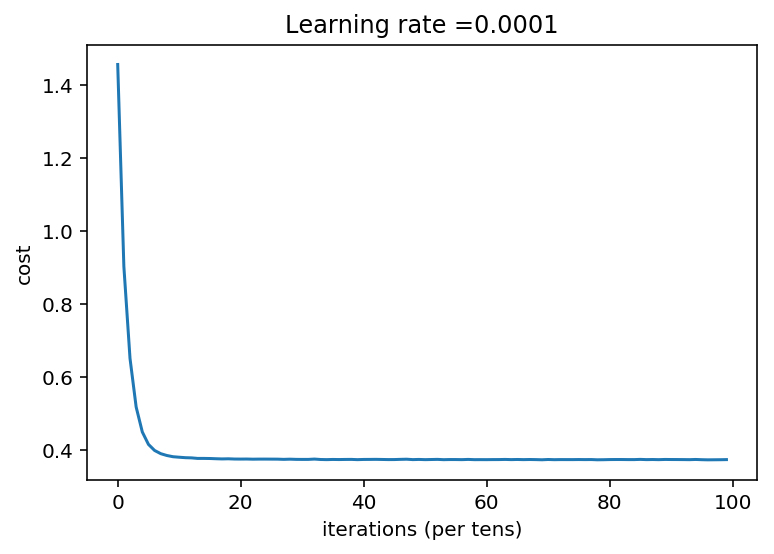

Parameters have been trained!
Train Accuracy: 0.8506629
Test Accuracy: 0.85460144


In [174]:
num1 = DNNtrain_X.shape[0]
parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = 0.0001, keep_prob=1,lamb=0.01,num_epochs = 500, minibatch_size=512, params = [256,128,2])

In [175]:
default_prob = get_probability(parameters, DNNval_X)[1,:]
roc_auc_score(DNNval_y[1,:], default_prob)

0.8165004677600622

In [176]:
print(classification_report(DNNval_y[1,:], default_prob>0.5))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92      7361
         1.0       0.65      0.20      0.31      1408

   micro avg       0.85      0.85      0.85      8769
   macro avg       0.76      0.59      0.61      8769
weighted avg       0.83      0.85      0.82      8769



C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Cost after epoch 0: 17504.457699
Cost after epoch 100: 109.061628
Cost after epoch 200: 93.162514
Cost after epoch 300: 90.435052
Cost after epoch 400: 67.341103


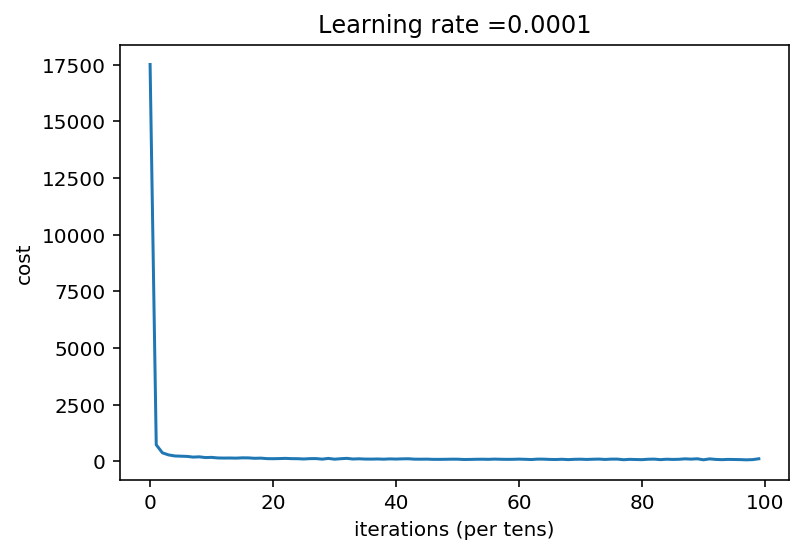

Parameters have been trained!
Train Accuracy: 0.8087812
Test Accuracy: 0.8065914


In [175]:
# cross validation
num1 = DNNtrain_X.shape[0]
learning_rates = [0.00001,0.0001,0.01,0.1]
params_all = [[100,50,2],[128,64,2],[64,32,2],[256,128,2],[256,64,2],[512,256,2],[512,128,2]]
keep_probs = [1,0.9,0.8]
lambs = [0.01,0.1,1,10]
minibatch_sizes = [256,512,1024]
epochs = [400,500,600]

aucl = []
for l in learning_rates:
    print('choose learning rate')
    print(l)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate=l)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucl.append(auc)
    print(auc)
    print('----------------------------')
maxaucl = max(aucl)
bestl = learning_rates[aucl.index(maxaucl)]
print('Best learning rate: {}'.format(bestl))
print('Best AUC: {}'.format(maxaucl))

auck = []
for k in keep_probs:
    print('choose dropout prob')
    print(k)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = k)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auck.append(auc)    
    print(auc)
    print('----------------------------')
maxauck = max(auck)
bestk = keep_probs[auck.index(maxauck)]
print('Best dropout prob: {}'.format(bestk))
print('Best AUC: {}'.format(maxauck))


aucp = []
for p in params_all:
    print('choose # nodes')
    print(p)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, params = p)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucp.append(auc)    
    print(auc)
    print('----------------------------')    
maxaucp = max(aucp)
bestp = params_all[aucp.index(maxaucp)]
print('Best # nodes: {}'.format(bestp))
print('Best AUC: {}'.format(maxaucp))


aucla = []    
for la in lambs:
    print('choose regularization param')
    print(la)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = la, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucla.append(auc)    
    print(auc)
    print('----------------------------')
maxaucla = max(aucla)
bestla = lambs[aucla.index(maxaucla)]
print('Best regularization param: {}'.format(bestla))
print('Best AUC: {}'.format(maxaucla))

aucmi = []
for mi in minibatch_sizes:
    print('choose minibatch size')
    print(mi)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = bestla,minibatch_size = mi, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucmi.append(auc)  
    print(auc)
    print('----------------------------')
maxaucmi = max(aucmi)
bestmi = minibatch_sizes[aucmi.index(maxaucmi)]
print('Best minibatch sizes: {}'.format(bestmi))
print('Best AUC: {}'.format(maxaucmi))

auce = []
for e in epochs:
    print('choose # epochs')
    print(e)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,num=num1,learning_rate = bestl, keep_prob = bestk, lamb = bestla,num_epochs = e,minibatch_size = mi, params = bestp)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auce.append(auc)  
    print(auc)
    print('----------------------------')
maxauce = max(auce)
beste = minibatch_sizes[auce.index(maxauce)]
print('Best # epochs: {}'.format(beste))
print('Best AUC: {}'.format(maxauce))   


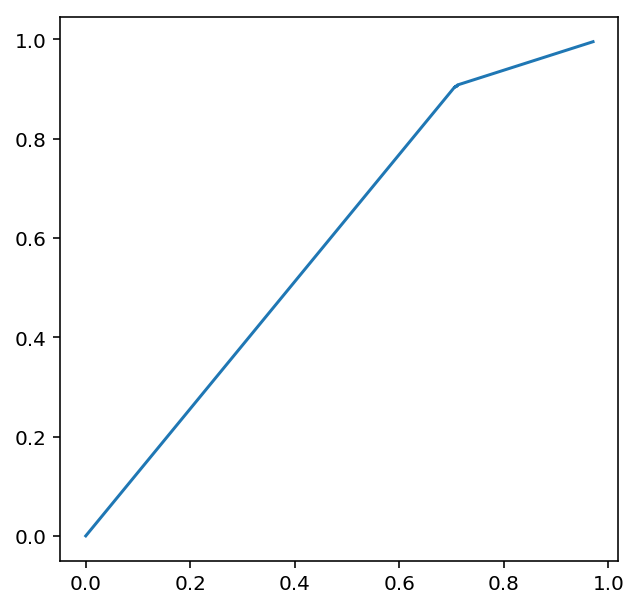

In [202]:
default_prob = get_probability(parameters, DNNval_X)[1,:]
n = 200
TPR = np.zeros((n,1))
FPR = np.zeros((n,1))
t = np.linspace(0.0, 1.0, n)
for i in range(n):
    TPR[i,0], FPR[i,0] = get_ROC(default_prob,t[i],DNNval_y[1,:])
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)

In [204]:
roc_auc_score(DNNval_y[1,:], default_prob)

0.6163920763297972

## Regression

In [53]:
regdata = rawdata[rawdata['target'] == 1]
# split the data
y_reg = np.log(regdata['GrossChargeOffAmount'].values + 1)
X_reg = regdata[numCols+catCols]
train_X_reg, test_X_reg, train_y_reg, test_y_reg = train_test_split(X_reg,y_reg,test_size=0.2,random_state=1)
train_X_reg, val_X_reg, train_y_reg, val_y_reg = train_test_split(train_X_reg,train_y_reg,test_size=0.2,random_state=1)


### Linear Regression

In [54]:
starttime = time.time()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])
lr.fit(train_X_reg, train_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, lr.predict(val_X_reg))))


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


time: 6.069469213485718
5.228185935579589


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Lasso

In [55]:
from sklearn.linear_model import Lasso
alphas = [0.01,0.05,0.1,0.2]
for a in alphas:
    print('alpha: {}'.format(a))
    lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Lasso(alpha = a))])
    lasso.fit(train_X_reg, train_y_reg)
    print(np.sqrt(metrics.mean_squared_error(val_y_reg, lasso.predict(val_X_reg))))
    


alpha: 0.01


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Pytho

3.749646858002965
alpha: 0.05


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.841699271846628
alpha: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.903918485165824
alpha: 0.2
3.935000033652722


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Ridge

In [75]:
alphas = [0.01,0.1,0.2,0.5]
for a in alphas:
    print('alpha: {}'.format(a))
    ridge = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Ridge(alpha = a))])
    ridge.fit(train_X_reg, train_y_reg)
    print(np.sqrt(metrics.mean_squared_error(val_y_reg, ridge.predict(val_X_reg))))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


alpha: 0.01


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


4.088307176250708
alpha: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


4.070576659036313
alpha: 0.2


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


4.053234201446227
alpha: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


4.037871160331523
alpha: 0.5
4.011039720848373


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Elastic Net

In [74]:
from sklearn.linear_model import ElasticNet
alphas = [0.01,0.05,0.1,0.2]
ratios = [0.1,0.3,0.5,0.7,0.9]
for a in alphas:
    for r in ratios:
        print('alpha: {}'.format(a))
        print('l1 ratio: {}'.format(r))
        elastic = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor',  ElasticNet(alpha = a,l1_ratio = r))])
        elastic.fit(train_X_reg, train_y_reg)
        print(np.sqrt(metrics.mean_squared_error(val_y_reg, elastic.predict(val_X_reg))))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


alpha: 0.01
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.7412382029144116
alpha: 0.01
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.741049406571738
alpha: 0.01
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.7469199528265786
alpha: 0.01
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.748500463006552
alpha: 0.01
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.7488208180455946
alpha: 0.05
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.79466108012809
alpha: 0.05
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.809367100361898
alpha: 0.05
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.82154300248706
alpha: 0.05
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8337942487969534
alpha: 0.05
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8387654415214234
alpha: 0.1
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.83131947689096
alpha: 0.1
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.855297403089508
alpha: 0.1
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8723341546700443
alpha: 0.1
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.887380358652593
alpha: 0.1
l1 ratio: 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.9010263352585284
alpha: 0.2
l1 ratio: 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.8731309625579637
alpha: 0.2
l1 ratio: 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.900752516057068
alpha: 0.2
l1 ratio: 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.91535294318555
alpha: 0.2
l1 ratio: 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


3.9251533816419824
alpha: 0.2
l1 ratio: 0.9
3.93259871012265


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Gradient Boosting

In [90]:
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 10,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    lgb.plot_importance(model)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.77428
Early stopping, best iteration is:
[31]	valid_0's rmse: 3.69843
time: 0.4085993766784668
3.698430869691903


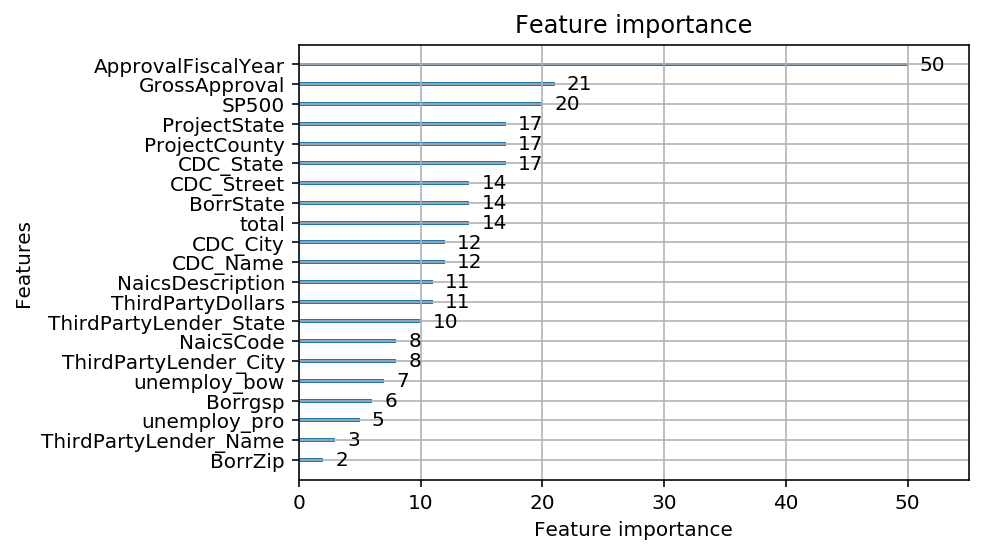

In [94]:
starttime = time.time()
modelR, pred_val_y = run_lgb(train_X_reg, train_y_reg, val_X_reg, val_y_reg)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_reg, pred_val_y)))

In [135]:
# try to implement with pipeline

class LGBM_Regressor:
    def fit(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y
        return self
    def fit_predict(self,val_X,val_y):
        params = {
            "objective" : "regression",
            "metric" : "rmse", 
            "num_leaves" : 10,
            "min_child_samples" : 100,
            "learning_rate" : 0.1,
            "bagging_fraction" : 0.7,
            "feature_fraction" : 0.5,
            "bagging_frequency" : 5,
            "bagging_seed" : 2018,
        }

        lgtrain = lgb.Dataset(self.train_X, label=self.train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
        pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
        return model, pred_val_y
lgbr = Pipeline(steps=[('preprocessor', preprocessor),
                  ('regressor',  LGBM_Regressor())])
lgbr.fit(train_X_reg,train_y_reg)
modelR, pred_val_y = lgbr.fit_predict(val_X_reg, val_y_reg)
print(np.sqrt(metrics.mean_squared_error(val_y_reg, pred_val_y)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.95383
[200]	valid_0's rmse: 3.96833
Early stopping, best iteration is:
[179]	valid_0's rmse: 3.94938
3.949375093657864


### DNN Regressor